## Car Time Penalized

In [23]:
using TrajectoryOptimization
using Plots, LinearAlgebra

Import the car model

In [24]:
model = Dynamics.car
model_d = rk3(model) # discrete dynamics
n = model.n # number of states
m = model.m; # number of control

Define numerical type

In [25]:
T = Float64;

Define initial and goals states

In [26]:
x0 = [0.0;0.0;0.0]
xf = [0.0;1.0;0.0];

Define cost functions, e.g., quadratic

In [27]:
Qf = 100.0*Diagonal(I,n)
Q = (1e-2)*Diagonal(I,n)
R = (1e-2)*Diagonal(I,m)

2×2 Diagonal{Float64,Array{Float64,1}}:
 0.01   ⋅  
  ⋅    0.01

Define constraints

In [28]:
u_bnd = 2.
bnd = BoundConstraint(n,m,u_min=-u_bnd,u_max=u_bnd)

goal_con = goal_constraint(xf)

Constraint{Equality}(getfield(TrajectoryOptimization, Symbol("#terminal_constraint#12")){Array{Float64,1}}([0.0, 1.0, 0.0]), getfield(TrajectoryOptimization, Symbol("#terminal_jacobian#13")){Int64}(3), 3, :goal, Array{Int64,1}[[1, 2, 3], []], :terminal, :x)

Set options

In [29]:
verbose=false
opts_ilqr = iLQRSolverOptions{T}(verbose=false,
    live_plotting=:off)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=false,
    opts_uncon=opts_ilqr,
    iterations=30,
    penalty_scaling=10.0)

opts_altro = ALTROSolverOptions{T}(verbose=false,
    opts_al=opts_al,
    R_minimum_time=15.0,
    dt_max=0.2,
    dt_min=1.0e-3);

Define a problem

In [31]:
N = 51

tf = 3.0
dt = 0.06

U = [ones(m) for k = 1:N-1]

obj = LQRObjective(Q,R,Qf,xf,N)

constraints = Constraints(N)
for k = 1:N-1
    constraints[k] += bnd
end
constraints[N] += goal_con

prob = Problem(model_d,obj,constraints=constraints,dt=dt,N=N,x0=x0,xf=xf)
initial_controls!(prob, U);

Solve problem

In [32]:
solve!(prob, opts_altro); # solve with ALTRO

┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:24


Define minimum time problem setting tf to :min

In [13]:
prob_mt = Problem(model_d,obj,constraints=constraints,
    dt=dt,x0=x0,N=N,tf=:min);

# use previous control trajectory to warm start
initial_controls!(prob_mt, prob.U);

Solve minimum time problem

In [14]:
solve!(prob_mt, opts_altro); # solve with ALTRO

┌ Info: Minimum Time Solve
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:111
┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:24


Plot state trajectories

In [15]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N]

x_min_time = [prob_mt.X[k][1] for k = 1:N]
y_min_time = [prob_mt.X[k][2] for k = 1:N];

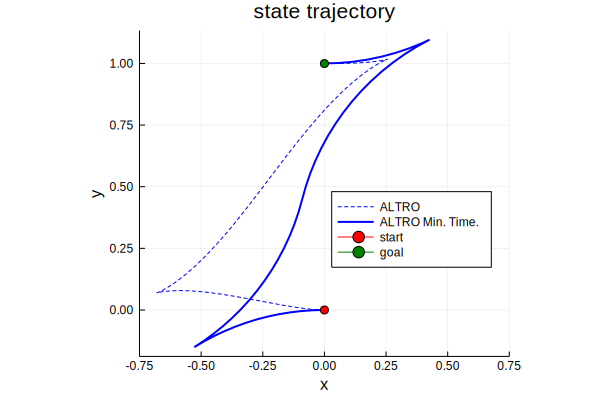

In [16]:
plot()
plot!(x,y,xlabel="x",ylabel="y",label="ALTRO",legend=:right,color=:blue,linestyle=:dash,ratio=:equal,title="state trajectory")
plot!(x_min_time,y_min_time,xlim=(-0.75,0.75),xlabel="x",ylabel="y",label="ALTRO Min. Time.",color=:blue,width=2,ratio=:equal,title="state trajectory")

plot!((x[1],y[1]),marker=:circle,color=:red,label="start")
plot!((x[end],y[end]),marker=:circle,color=:green,label="goal")

Compute total time

In [19]:
@show tt = total_time(prob)
@show tt_mt = total_time(prob_mt);

tt = total_time(prob) = 3.0
tt_mt = total_time(prob_mt) = 1.3222236191640016


Plot control trajectories

In [20]:
t_range = range(0, stop=tt, length=N)[1:end-1]
u1 = [prob.U[k][1] for k = 1:N-1]
u2 = [prob.U[k][2] for k = 1:N-1];

In [21]:
t_range_mt = range(0, stop=tt_mt, length=N)[1:end-1]
u1_mt = [prob_mt.U[k][1] for k = 1:N-1]
u2_mt = [prob_mt.U[k][2] for k = 1:N-1];

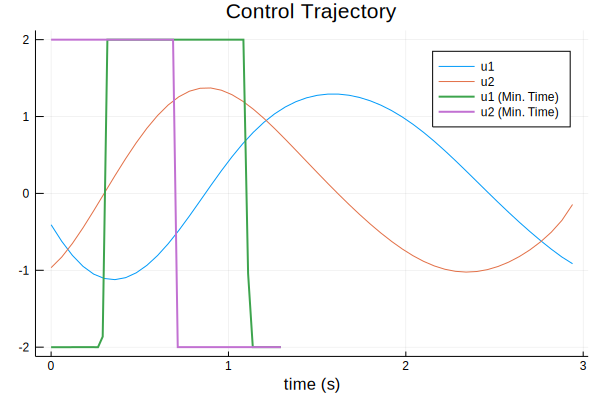

In [22]:
plot(title="Control Trajectory",xlabel="time (s)")
plot!(t_range,u1,label="u1")
plot!(t_range,u2,label="u2")
plot!(t_range_mt,u1_mt,width=2,label="u1 (Min. Time)")
plot!(t_range_mt,u2_mt,width=2,label="u2 (Min. Time)")